In [2]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')


In [3]:
def retrieveData(fromCSV=False, numberOfStocks=50, daysSince=30, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    if (fromCSV == True):
        print ("Returning stored data.")
        (rawdata, spreads) = ((pd.read_csv('data/close.csv')).set_index('Date'), (pd.read_csv('data/spreads.csv')).set_index('Date'))
    else:
        downloadedData = retrieve.init(fromCSV, numberOfStocks, daysSince)
        rawdata = downloadedData['Close']
        spreads = (downloadedData['High'] - downloadedData['Low'])/(downloadedData['Close'])
        rawdata.to_csv('./data/close.csv')
        spreads.to_csv('./data/spreads.csv')

    companies = rawdata.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, rawdata)
    keyStats = calc.get_intersection_point(EMA_df, rawdata)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(100*rawdata.pct_change()[-latestWindow:].min(),2)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(rawdata, keyStats, 3)
    return (rawdata, EMA_df, keyStats, spreads)

In [4]:
def showData(rawdata, EMA_df, keyStats, filterSet):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(rawdata, EMA_df, filteredCompanies, limit=20)

Returning stored data.
EMA Dataframe calculated.
Intersection points found.
Absolute and Relative Mins calculated.
Main companies filtered. 500 outstanding companies.
Displaying 20 first companies
Company RCL


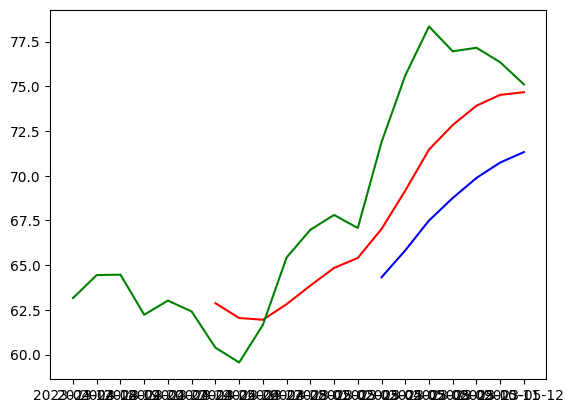

Company HAS


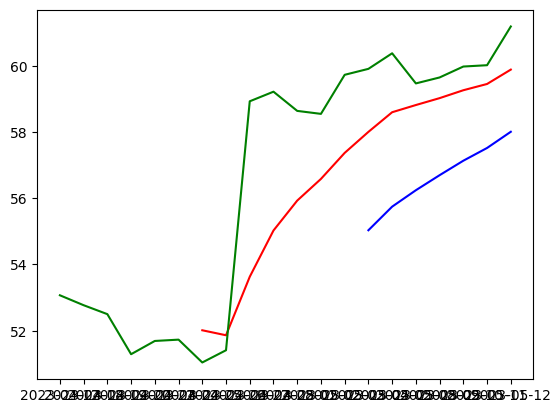

Company LLY


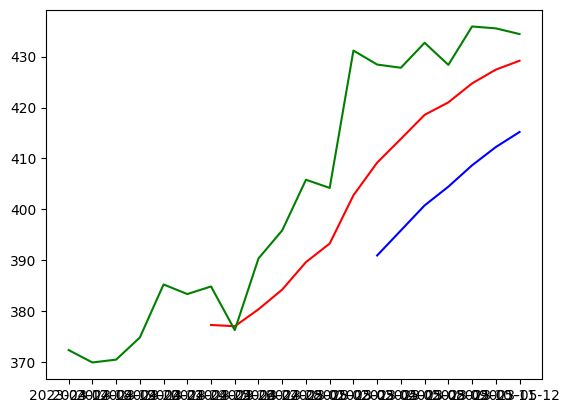

Company CMG


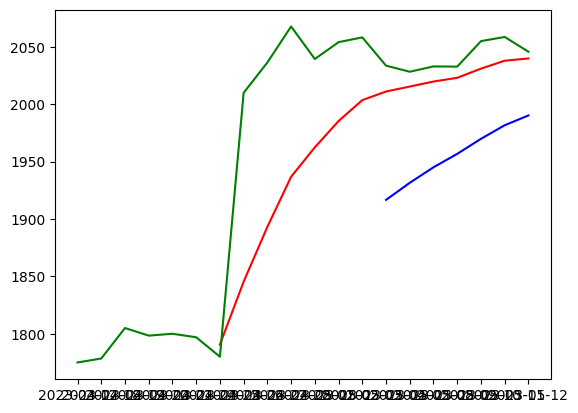

Company TAP


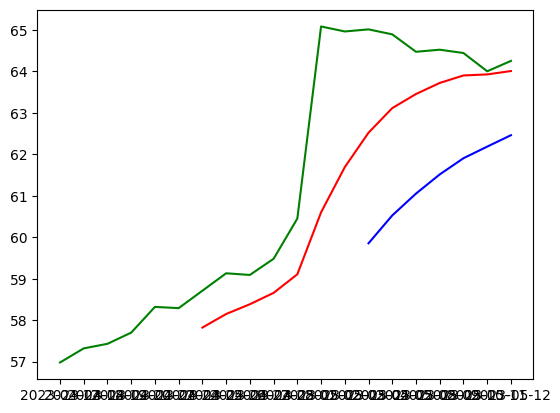

Company VMC


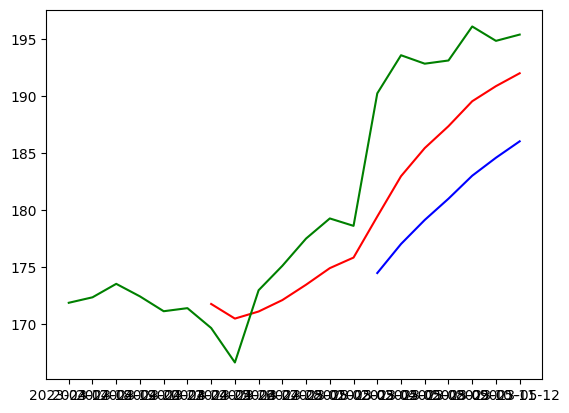

Company AIZ


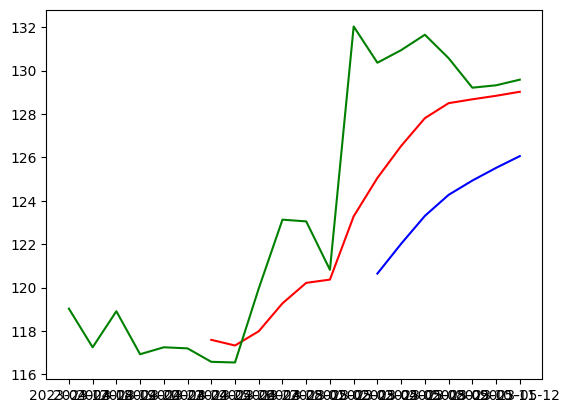

Company MLM


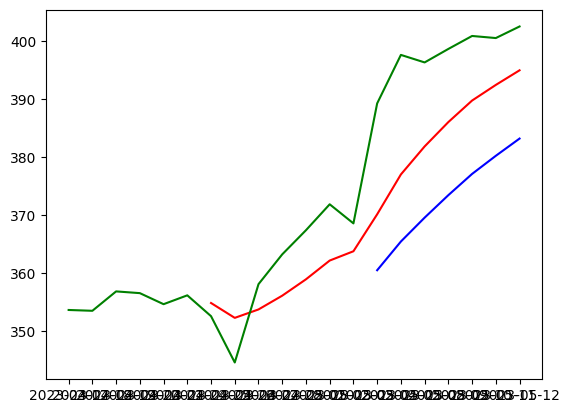

Company MNST


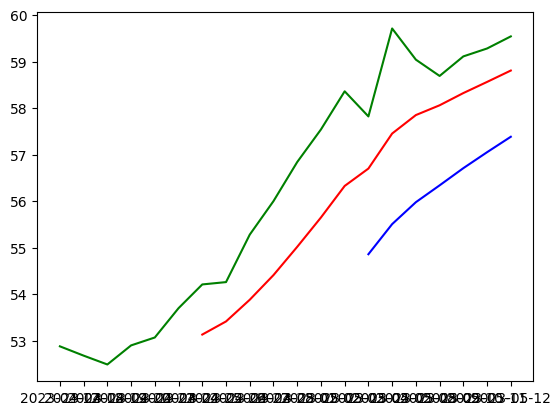

Company BALL


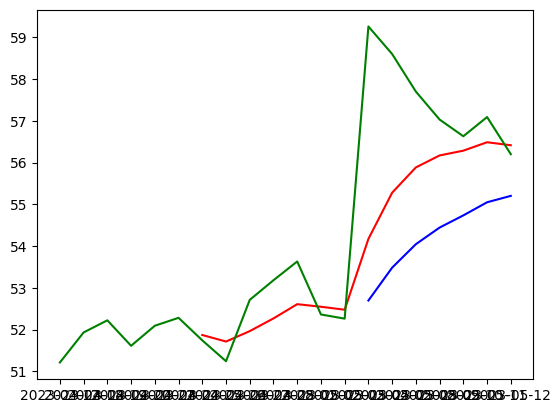

Company LYV


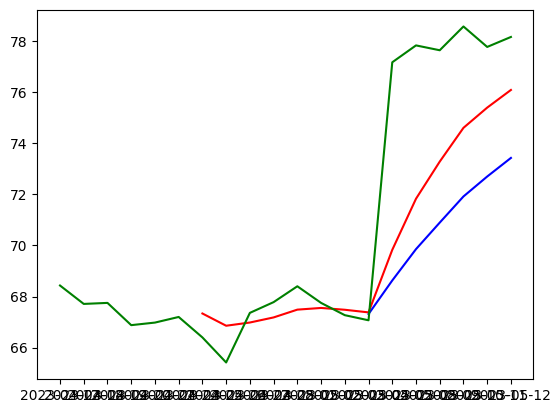

Company META


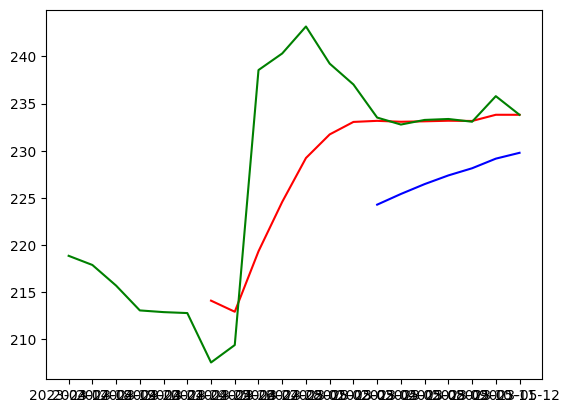

Company GNRC


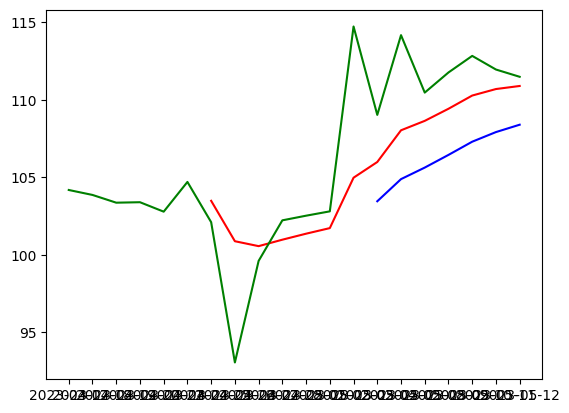

Company MDLZ


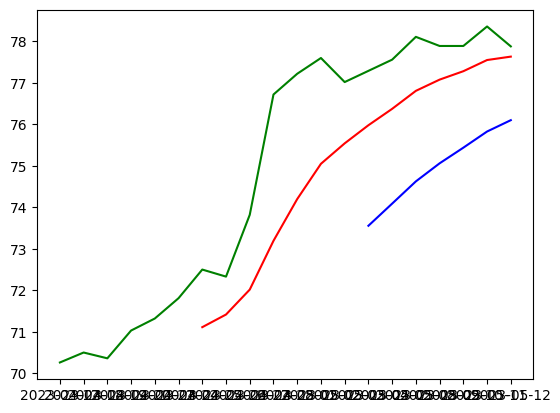

Company PNR


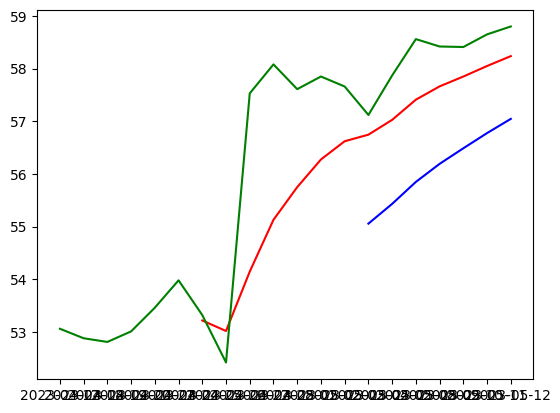

Company NCLH


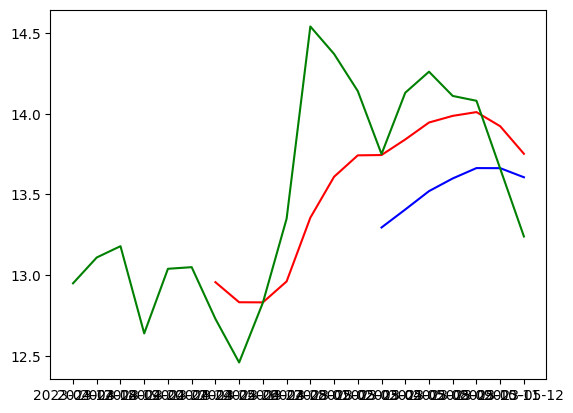

Company VRSK


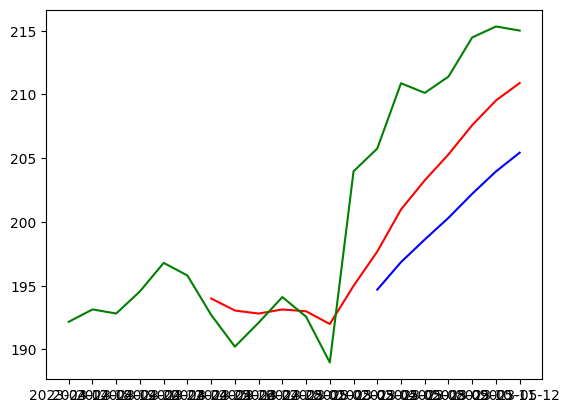

Company BIIB


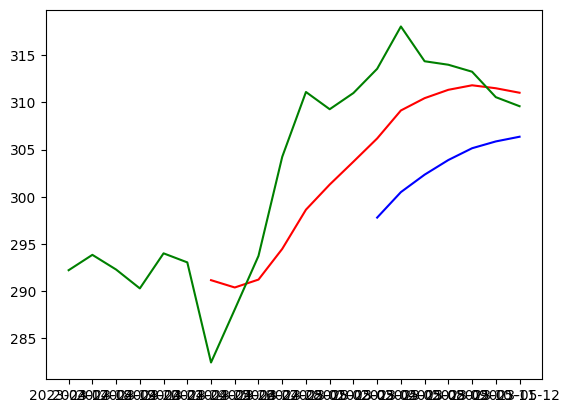

Company MSFT


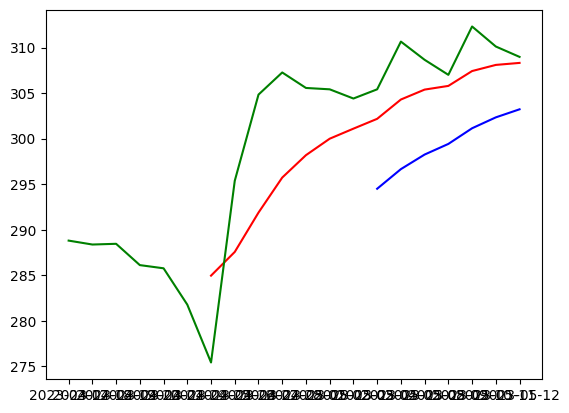

Company DVA


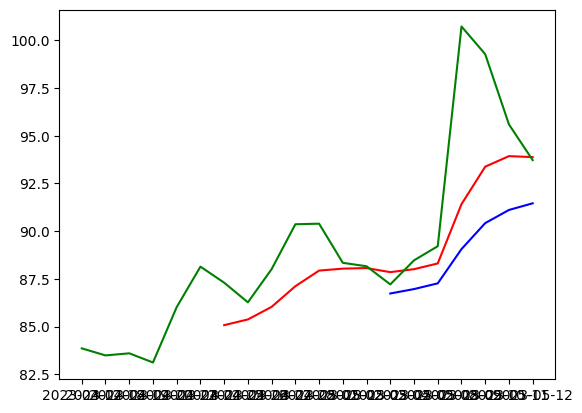

In [8]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

filterSet = dict({
    #"aboveAvgRatio":0.01, 
    #"aboveMinAbs":0.01, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":1
     })

def run_application():
    #(fromCSV, numberOfStocks, timeframes:{daysSince, qema_period, sema_period}, filters: {aboveAvgRatio, aboveMinAbs, aboveRatioContr})
    (rawdata, EMA_df, keyStats, spreads)= retrieveData(fromCSV=True, numberOfStocks=500)
    showData(rawdata, EMA_df, keyStats, filterSet)
    return (rawdata, EMA_df, keyStats, spreads)

(rawdata, EMA_df, keyStats, spreads) = run_application()



In [6]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')



In [7]:
(closeData, spreads) = retrieve.init(fromCSV=False, numberOfStocks=10, daysSince=30)
spreads.head()

Requested days: 30.
Requested stocks: 10.
[*********************100%***********************]  10 of 10 completed
             Adj Close                                                   
                   AAP        ABBV         ABT         ACN        ADBE   
Date                                                                     
2023-04-17  126.870003  161.179993  104.519997  279.980011  377.920013  \
2023-04-18  126.650002  159.589996  104.150002  279.959991  377.549988   
2023-04-19  128.110001  161.210007  112.290001  279.899994  380.109985   
2023-04-20  128.369995  161.740005  110.349998  275.549988  380.260010   
2023-04-21  128.210007  162.410004  111.660004  276.329987  377.670013   
2023-04-24  126.830002  164.080002  110.400002  277.250000  377.339996   
2023-04-25  123.779999  164.899994  109.970001  270.700012  369.589996   
2023-04-26  122.330002  161.800003  108.750000  271.209991  363.059998   
2023-04-27  124.900002  148.869995  109.500000  275.450012  371.420013   

ValueError: too many values to unpack (expected 2)